# Quantium Retail Trial Analysis

## Business Objective
The objective is to analyze the impact of a trial intervention in stores 77, 86, and 88 by comparing their performance (for total sales and number of customers) to control stores during March 2019–June 2019.  

## Methodology

The raw dataset is extremely granular. It includes line by line transactions (including such details as date, transaction id, product name, loyalty card number, store number etc). There are 271 stores and 12 months of transactions from each store. 

We aim to understand whether the trial worked on a monthly basis. The trial was held at stores 77, 86, and 88. In order to assess whether the trial had any impact, we must be able to compare the trial performances against a baseline. Thus, we will find a store (from among the 271) that is most similar to the trial store being assessed to make the comparison. 

Our methodology is as follows:  
- Compute monthly store metrics for each store (total sales, number of customers etc)
- Find control stores that are most similar to each trial store. This will be done on the basis of **correlation** and **magnitude distance**. 
- Scale control metrics, calculate percentage differences, and perform t-tests for significance.
- Visualize trial vs. control performance by plotting it with confidence intervals.


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib as pyplot
import numpy as np
import scipy as sp
from scipy.stats import pearsonr

In [14]:
qvi1 = pd.read_csv(r'/Users/zayed/Documents/Data analysis projects/Forage/Quantium/QVImerged.csv')

qvi = qvi1.copy()
qvi.drop(columns='Unnamed: 0', inplace=True)
qvi.head()

,date,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,dayofmonth,dayofweek,year,month,pkt_size,company,lifestage,premium_customer
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,17,Wednesday,2018,10,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,14,Tuesday,2019,5,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,20,Monday,2019,5,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,17,Friday,2018,8,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,18,Saturday,2018,8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [15]:
qvi.dtypes

date                 object
store_nbr             int64
lylty_card_nbr        int64
txn_id                int64
prod_nbr              int64
prod_name            object
prod_qty              int64
tot_sales           float64
dayofmonth            int64
dayofweek            object
year                  int64
month                 int64
pkt_size              int64
company              object
lifestage            object
premium_customer     object
dtype: object

In [16]:
# add a unique indentifier for the month
qvi['yearmonth'] = qvi['year'] * 100 + qvi['month']

The dataset captures every transaction from July 2018 to June 2019. Each row is a transaction: a date, a store, a customer, a quantity, a sale.  

Our objective is to compare differences in store performance at the monthly level, so we will begin by aggregating the data for each month.

In [17]:
# create measures grouped by store number and month
measures = qvi.groupby(['store_nbr', 'yearmonth']).agg(
    totsales = ('tot_sales', 'sum'), 
    n_customers = ('lylty_card_nbr', 'nunique'), 
    txn_per_cx = ('txn_id', lambda x: x.nunique() / qvi.loc[x.index, 'lylty_card_nbr'].nunique()), #number of unique transactions divided by unique cxs
    n_chipspertx = ('prod_qty', lambda x: x.sum()/ qvi.loc[x.index, 'txn_id'].nunique()), # sum of prod qty divided by unique txns
    avgpriceperunit = ('tot_sales', lambda x: x.sum()/ qvi.loc[x.index, 'prod_qty'].sum()) # sum of tot_sales divided by sum of prod_qty
).reset_index().sort_values(['store_nbr', 'yearmonth'])
measures

,store_nbr,yearmonth,totsales,n_customers,txn_per_cx,n_chipspertx,avgpriceperunit
0,1,201807,188.9,47,1.042553,1.183673,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.203390,3.776056
3,1,201810,175.4,39,1.025641,1.275000,3.439216
4,1,201811,184.8,44,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...
3160,272,201902,385.3,44,1.068182,1.893617,4.329213
3161,272,201903,421.9,48,1.062500,1.901961,4.349485
3162,272,201904,445.1,54,1.018519,1.909091,4.239048
3163,272,201905,314.6,34,1.176471,1.775000,4.430986


In [18]:
# Now let's filter out the stores without records in all 12 months, and then narrowing down to pre trial months
stores = measures.groupby('store_nbr').size().reset_index(name='size').query('size == 12') #stores with 12 months
measures = measures[measures['store_nbr'].isin(stores['store_nbr'])] #filtering measures for stores with 12 months
pretrialmeasures = measures[measures['yearmonth'] < 201902] # filtering measures to months to months before Feb 2019

pretrialmeasures

,store_nbr,yearmonth,totsales,n_customers,txn_per_cx,n_chipspertx,avgpriceperunit
0,1,201807,188.9,47,1.042553,1.183673,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.203390,3.776056
3,1,201810,175.4,39,1.025641,1.275000,3.439216
4,1,201811,184.8,44,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...
3155,272,201809,294.5,31,1.129032,1.971429,4.268116
3156,272,201810,405.1,41,1.146341,2.000000,4.309574
3157,272,201811,355.8,39,1.102564,1.930233,4.286747
3158,272,201812,363.1,43,1.000000,1.883721,4.482716


### Creating a correlation score and a magnitude distance score, and then combine them for a composite score


As we can see below, there are 271 stores. Our trial stores are store number 77, 86 and 88.  

To see if there was a significant difference in sales and customer visits for these three stores during the trial months, we must be able to compare them with a control. That is, a store that is very similar to the trial store, but was not part of the trials. This store will act as a baseline from which we can assess whether the trial made any real changes in sales or customer visits. 

From among the 271 stores, we will find the one that is most similar to each store, so that we can choose them as a control. 

This raises another question. How do we define 'most similar'? 

We will do so based on two measures: correlation and magnitude. 
1. We want both stores to move similarly through time. This means that they will have similar rises and falls through the pretrial months, capturing similar trends. Thus, we will use **correlation** as our first measure. 
2. It is not enough for both stores to move in a similar manner. They must also have similar amounts of sales/customers. That is, the absolute value of our relevant metrics must be similar. Even if they move similarly, we cannot have a trial store with 150 customers, and our control with 450 customers. The absolute difference is too large. Thus will use a **magnitude score** as our second measurement. 

Finally, we will combine the two scores into a composite score so that we have a single value to use for our comparisons. 

In [19]:
measures.store_nbr.nunique()

259

In [20]:
# create variables to store different kinds of stores
pretrial_stores = pretrialmeasures.store_nbr.unique()

trial_stores = [77,86,88]

comparison_stores = [x for x in pretrial_stores if x not in trial_stores]



### Correlation
The function below accepts two inputs: the trial store number (i) and the column used for calculating correlations.

It computes the correlation between the specified trial store and all other stores, returning the results in a neatly formatted table.

In [21]:
def calculate_correlation(i, column):
    rows = []
    for x in comparison_stores:
        r = np.corrcoef(pretrialmeasures[pretrialmeasures['store_nbr'] == i][column], pretrialmeasures[pretrialmeasures['store_nbr'] == x][column])[0,1]

        rows.append({
            'Store1' : i,
            'Store2': x,
            'correlation' : r
        })
    return pd.DataFrame(rows)

In [22]:
# Let us examine the function using trial store 77
calculate_correlation(77, 'totsales')

,Store1,Store2,correlation
0,77,1,-0.005382
1,77,2,-0.251183
2,77,3,0.660447
3,77,4,-0.347846
4,77,5,-0.139048
...,...,...,...
251,77,268,0.395460
252,77,269,-0.466370
253,77,270,0.274854
254,77,271,0.195190


Amazing. The function works as expected. 

### Magnitude distance score

Now we will write another function to calculate the magnitude score, which will capture the absolute difference in the selected column for the trial store. 

Formula for magnitude distance:
1.	Compute the raw difference between the control and trial stores.
2.	Standardize the result using min-max scaling.

In [23]:
def magnitude_table(store, column):
    mag_table = pretrialmeasures[pretrialmeasures['store_nbr'] == store].merge(pretrialmeasures[pretrialmeasures['store_nbr'].isin(comparison_stores)], on = 'yearmonth', how = 'inner')
    mag_table['rawdiff'] = abs(mag_table[f"{column}_x"] - mag_table[f"{column}_y"])
    min_max_permonth = mag_table.groupby('yearmonth').agg(
        mini = ('rawdiff', 'min'), 
        maxi = ('rawdiff', 'max')       
    ).reset_index()
    combined = mag_table.merge(min_max_permonth, on = 'yearmonth')
    combined['standardized'] = 1 - ((combined.rawdiff - combined.mini) / (combined.maxi - combined.mini))
    final = combined.groupby(['store_nbr_x', 'store_nbr_y']).standardized.mean().reset_index()
    final.columns = ['Store1', 'Store2', 'standardized']
    return final

In [24]:
magnitude_table(77, 'totsales')

,Store1,Store2,standardized
0,77,1,0.953559
1,77,2,0.936993
2,77,3,0.343363
3,77,4,0.178591
4,77,5,0.563416
...,...,...,...
251,77,268,0.963508
252,77,269,0.453583
253,77,270,0.456959
254,77,271,0.571390


## Finding control stores for each trial store

Now that we have both functions we need to find the control store, we will combine the correlation scores and magnitude distance scores into a composite score.  This will allow us to identify the most suitable control store for each trial store.

The function will return the store with the highest overall score, providing a clear choice for the control store.

In [25]:
# Now, we will find the highest combined score (combination of magnitude and correlation) for each store 

def find_control_store(store):
    cte_totsales = magnitude_table(store, 'totsales').merge(calculate_correlation(store, 'totsales'), on = ['Store1', 'Store2'])
    cte_totsales['totsales_score']= (cte_totsales.standardized * 0.5) + (cte_totsales.correlation * 0.5)

    cte_ncx = magnitude_table(store, 'n_customers').merge(calculate_correlation(store, 'n_customers'), on = ['Store1', 'Store2'])
    cte_ncx['ncx_score']= (cte_ncx.standardized * 0.5) + (cte_ncx.correlation * 0.5)
    

    ctefinal = cte_totsales.merge(cte_ncx, on = ['Store1', 'Store2'])

    ctefinal['finalscore'] = ctefinal.ncx_score/2 + ctefinal.totsales_score/2
    return ctefinal.loc[ctefinal.finalscore == ctefinal.finalscore.max()][['Store1', 'Store2', 'finalscore']]

In [26]:
# let us find the control stores for all the stores in which the experimental layout has been implemented
for item in trial_stores:
    display(find_control_store(item))

,Store1,Store2,finalscore
217,77,233,0.979343


,Store1,Store2,finalscore
144,86,155,0.908524


,Store1,Store2,finalscore
221,88,237,0.749936


The tables above give us the best control store for each trial store. 

# Visual check of the above  

We can write a function to plot the performance of the stores for a visual assessment of their similarity. Let us see if each control store passes the eye test. 

In [29]:
import matplotlib.pyplot as plt


def chart_comparison(store, metric):
    pretrialmeasures1 = pretrialmeasures.copy()
    control = find_control_store(store)['Store2'].iloc[0]
    pretrialmeasures1['storetype'] = pretrialmeasures1['store_nbr'].apply(
        lambda x : 'Trial' if x == store else ('Control' if x == control else 'Other')) # This categorizes all stores. Our selected store will be categorized as 'trial', its control as 'control', and all others as 'other'


    past_sales = pretrialmeasures1[pretrialmeasures1.yearmonth < 201903].groupby(['yearmonth', 'storetype'])[metric].mean().reset_index()
    past_sales.yearmonth = pd.to_datetime(past_sales['yearmonth'], format = '%Y%m')


    for item in past_sales.storetype.unique():
        subset = past_sales[past_sales.storetype == item]
        plt.plot(subset['yearmonth'], subset[metric], label = item)
    plt.xlabel('Month of operation')
    plt.ylabel(f'{metric}')
    plt.title(f'{metric} by month')
    plt.legend()
    plt.grid(True)

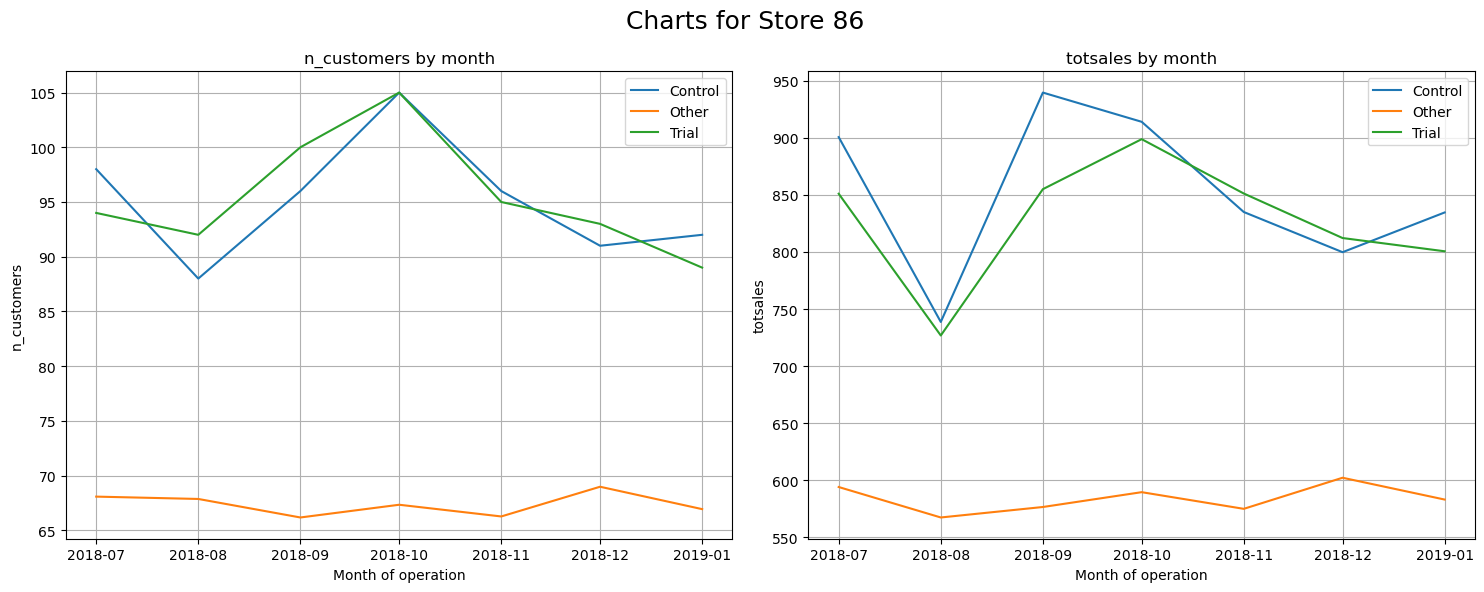

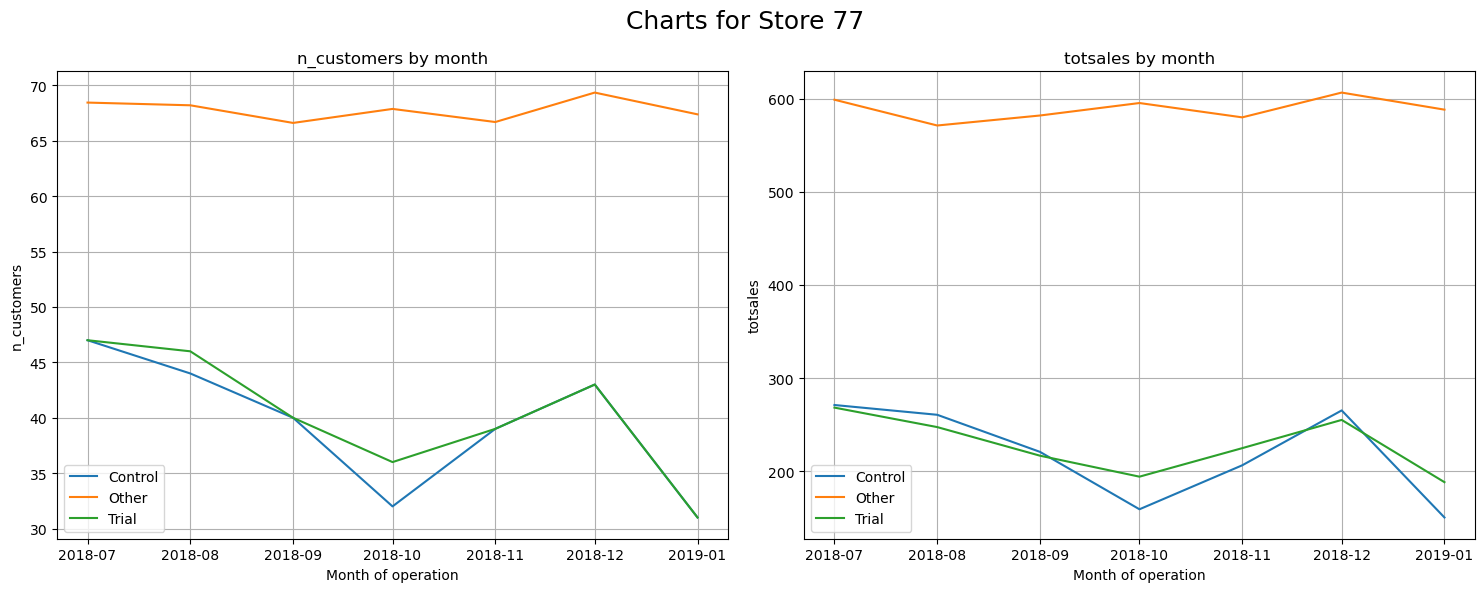

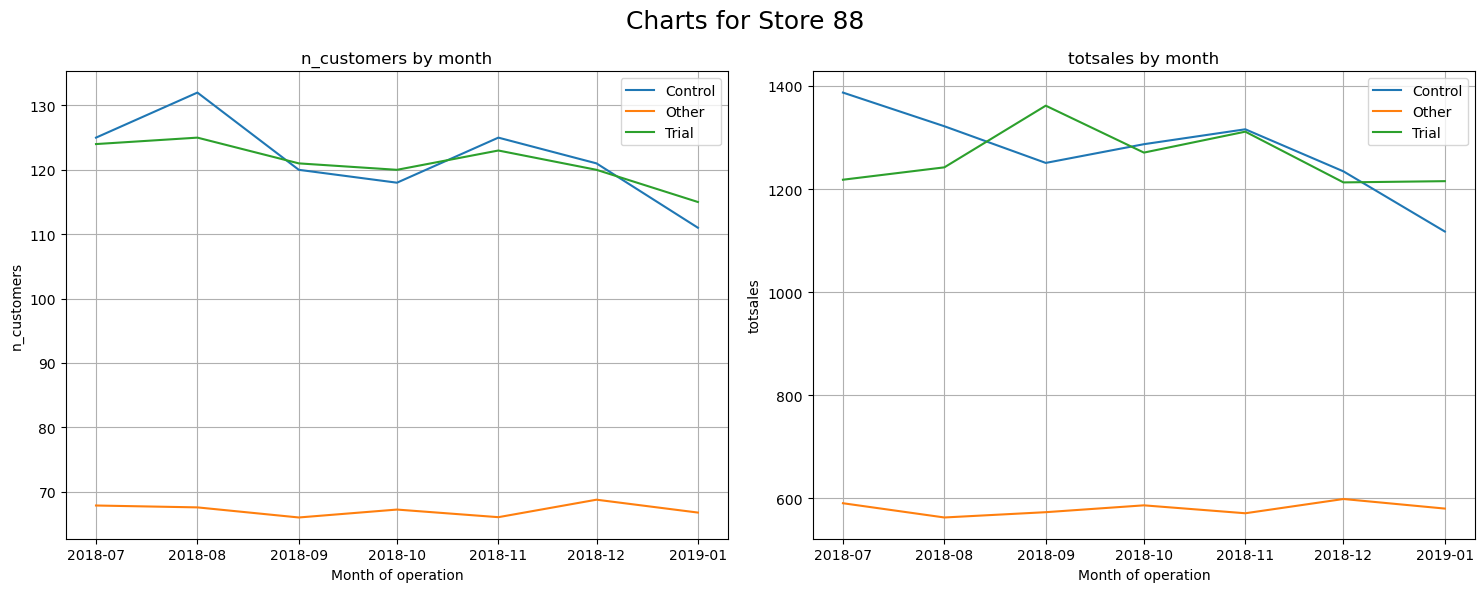

In [31]:
# I will display here both charts (total sales and number of customers) for each store compared with its control

plt.figure(figsize=(15,6))

plt.suptitle('Charts for Store 86', fontsize = 18)
plt.subplot(1,2,1)
chart_comparison(86, 'n_customers')

plt.subplot(1,2,2)
chart_comparison(86, 'totsales')
plt.tight_layout()

###

plt.figure(figsize=(15,6))

plt.suptitle('Charts for Store 77', fontsize = 18)
plt.subplot(1,2,1)
chart_comparison(77, 'n_customers')

plt.subplot(1,2,2)
chart_comparison(77, 'totsales')
plt.tight_layout()

###
plt.figure(figsize=(15,6))

plt.suptitle('Charts for Store 88', fontsize = 18)
plt.subplot(1,2,1)
chart_comparison(88, 'n_customers')

plt.subplot(1,2,2)
chart_comparison(88, 'totsales')
plt.tight_layout()

All contol stores seem to be quite similar to the trial stores when compared to all other stores (orange line). 

# Trial assessment


## Objective
Now that we have control stores for each trial store, let us now assess whether the trials resulted in a significant difference in sales/customer visits. We will do so, by calculating the difference in sales/customers between both stores, expressed as a percentage. Then a T-test can be used to assess whether this difference is significant. 

### Methodology
Run a t-test on the percentage differences of the two stores during the trial period.  

Null hypothesis: difference is 0  
Alternative hypothesis: difference is not 0

We will run a single sample T-test on each month, to see if the sales/number of customers in the trial store for that month differed from that of the control store. 

The formula for a t-test in this situation will be:  
Percentage difference / standard error  

The formula for standard error is standard deviation / sqrt of sample size (ie $ \frac{s}{\sqrt{n}}  $)

However, because the standard error here would be the standard deviation divided by 1 (as the sample size is 1; we are comparing one month each time), we only need to divide the percentage difference by $s$ ie the standard deviation, as the division by 1 wouldn't change the result. 

In [32]:
trial_stores
control_stores = {}
results = {}

for store in trial_stores:
    control_store = find_control_store(store)
    control_stores[store] = control_store['Store2'].iloc[0]

control_stores

{77: 233, 86: 155, 88: 237}

In [55]:
from scipy.stats import t

def compare_trialvscontrol(trialstore,controlstore, metric):

    # step 1: scale the control store metrics so they are rougly equivalent to the trial store metrics. 

    scaling_factor = pretrialmeasures[pretrialmeasures.store_nbr == trialstore][metric].sum() / pretrialmeasures[pretrialmeasures.store_nbr == controlstore][metric].sum()

    scaled_control = measures[measures.store_nbr == controlstore][['store_nbr', 'yearmonth', 'totsales', 'n_customers']].copy()
    scaled_control['scaled_customers'] = scaled_control.n_customers * scaling_factor
    scaled_control['scaled_sales'] = scaled_control.totsales * scaling_factor

    #step 2: find percentage difference between the two stores during the pre trial months

    trial_full = measures[measures.store_nbr == trialstore][['store_nbr', 'yearmonth', 'totsales', 'n_customers']]
    merged = trial_full.merge(scaled_control, on = 'yearmonth')

    if metric == 'n_customers':
        merged['percentage_diff'] = abs(merged[metric +'_x'] - merged.scaled_customers )/ merged.scaled_customers
    else:
        merged['percentage_diff'] = abs(merged[metric +'_x'] - merged.scaled_sales )/ merged.scaled_sales

    # step 3: calculate standard devation of the percentage differences based on the pre trial months (n = 8, therefore df = n-1 = 7)
    standard_deviation = merged[merged.yearmonth < 201902].percentage_diff.std()

    # step 4: calculate differences during trial months, and then divide by standard deviation to get t value
    trial = measures[measures.store_nbr == trialstore][['store_nbr', 'yearmonth', 'totsales', 'n_customers']]
    answer = trial.merge(scaled_control, on = 'yearmonth')

    if metric == 'n_customers':
        answer['percentage_diff'] = abs(answer[metric +'_x'] - answer.scaled_customers) / answer.scaled_customers
    else:
        answer['percentage_diff'] = abs(answer[metric +'_x'] - answer.scaled_sales) / answer.scaled_sales


    # divide by std dev to calculate T value
    answer['tvalue'] = answer['percentage_diff'] / standard_deviation

    t_critical = t.ppf(0.95, df = 7)

    answer['yearmonth'] = pd.to_datetime(answer['yearmonth'], format = '%Y%m')

    # step 5: Calculate confidence interval and plot the charts to observe if the differences are significant
    plt.figure(figsize=(16,8))
    plt.plot(answer['yearmonth'], answer[f'{metric}_x'], label = f'Trial store {trialstore}')

    if metric == 'n_customers':
        plt.plot(answer['yearmonth'], answer['scaled_customers'], label = f'Control store {controlstore}')
    else:
        plt.plot(answer['yearmonth'], answer['scaled_sales'], label = f'Control store {controlstore}')
    

    ci = t_critical * standard_deviation

    if metric == 'n_customers':
        plt.fill_between(
            answer['yearmonth'],
            answer['scaled_customers'] * (1 + ci),
            answer['scaled_customers'] * (1 - ci),
            alpha=0.2, color='gray', label='95% CI'
        )
    else:
        plt.fill_between(
            answer['yearmonth'],
            answer['scaled_sales'] * (1 + ci),
            answer['scaled_sales'] * (1 - ci),
            alpha=0.2, color='gray', label='95% CI'
        )

    plt.axvspan(pd.Timestamp("2019-02"), pd.Timestamp("2019-04"), color='green', alpha=0.2, label="Trial Period")
    plt.ylim(0)

    plt.xlabel('Month')
    if metric == 'n_customers':
        plt.ylabel('Number of Customers')
        plt.title(f'Number of Customers: Trial Store {trialstore} vs Control Store {controlstore}')
    else:
        plt.ylabel('Total sales')
        plt.title(f'Total Sales: Trial Store {trialstore} vs Control Store {controlstore}')
    plt.legend()
    plt.grid(True)

    return

In [56]:
control_stores

{77: 233, 86: 155, 88: 237}

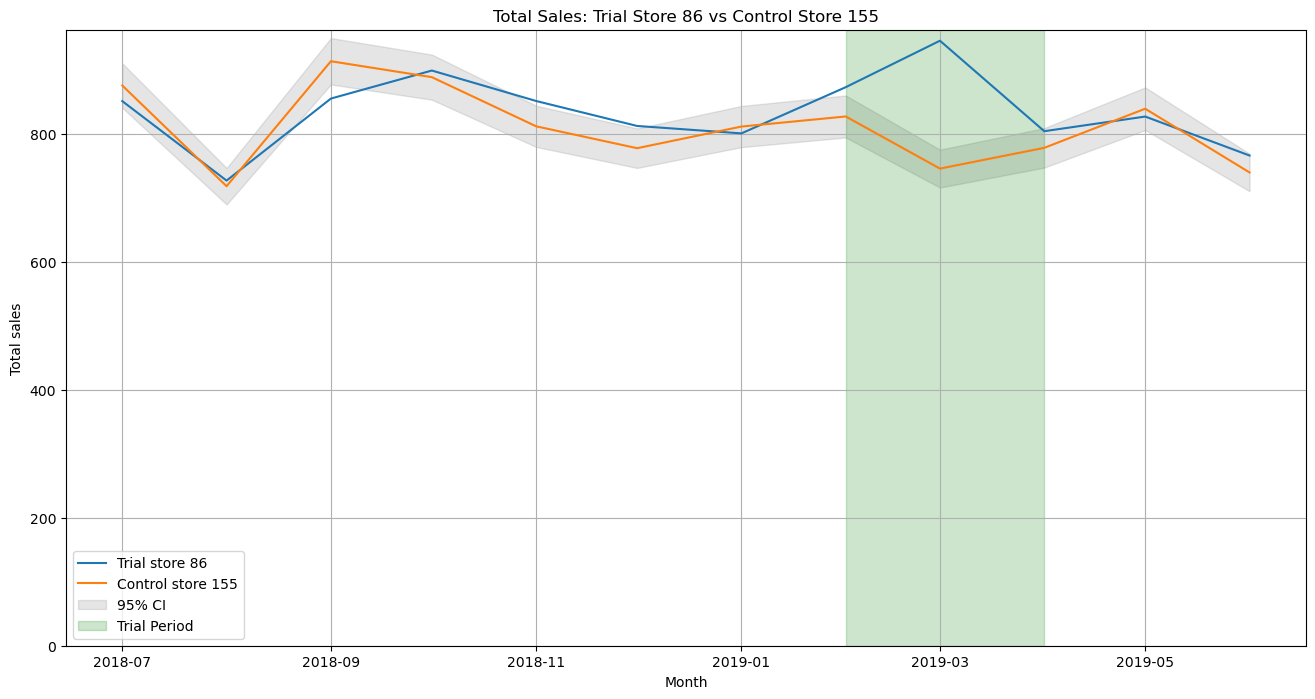

In [57]:
compare_trialvscontrol(86,155, 'totsales')

Our function appears to work. That's great news. Let us re-write the function above to express the difference numerically, in a table. 

In [58]:
# Statistical significance

def get_Tscores(trialstore, controlstore, metric):
    # Step 1: Scale the control store metrics so they are rougly equivalent to the trial store metrics. 

    scaling_factor = pretrialmeasures[pretrialmeasures.store_nbr == trialstore][metric].sum() / pretrialmeasures[pretrialmeasures.store_nbr == controlstore][metric].sum()

    scaled_control = measures[measures.store_nbr == controlstore][['store_nbr', 'yearmonth', 'totsales', 'n_customers']].copy()
    scaled_control['scaled_customers'] = scaled_control.n_customers * scaling_factor
    scaled_control['scaled_sales'] = scaled_control.totsales * scaling_factor

    #Step 2: Find percentage difference between the two stores during the pre-trial months

    trial_full = measures[measures.store_nbr == trialstore][['store_nbr', 'yearmonth', 'totsales', 'n_customers']]
    merged = trial_full.merge(scaled_control, on = 'yearmonth')

    if metric == 'n_customers':
        merged['percentage_diff'] = abs(merged[metric +'_x'] - merged.scaled_customers )/ merged.scaled_customers
    else:
        merged['percentage_diff'] = abs(merged[metric +'_x'] - merged.scaled_sales )/ merged.scaled_sales

    # step 3: Calculate standard devation of the percentage differences based on the pre trial months (n = 8, therefore df = n-1 = 7)
    standard_deviation = merged[merged.yearmonth < 201902].percentage_diff.std()

    # step 4: Calculate differences during trial months, and then divide by standard deviation to get t value
    trial = measures[measures.store_nbr == trialstore][['store_nbr', 'yearmonth', 'totsales', 'n_customers']]
    answer = trial.merge(scaled_control, on = 'yearmonth')

    if metric == 'n_customers':
        answer['percentage_diff'] = abs(answer[metric +'_x'] - answer.scaled_customers) / answer.scaled_customers
    else:
        answer['percentage_diff'] = abs(answer[metric +'_x'] - answer.scaled_sales) / answer.scaled_sales


    # divide by std dev to calculate T value
    answer['tvalue'] = answer['percentage_diff'] / standard_deviation

    t_critical = t.ppf(0.95, df = 7)

    answer['yearmonth'] = pd.to_datetime(answer['yearmonth'], format = '%Y%m')

    x = answer[(answer.yearmonth > '2019-01-01') & (answer.yearmonth < '2019-05-01')][['store_nbr_x', 'store_nbr_y', 'yearmonth', 'tvalue']]
    x['critical_tvalue'] = t_critical
    return x

In [59]:
get_Tscores(77, 233, 'totsales')

,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,77,233,2019-02-01,1.223912,1.894579
8,77,233,2019-03-01,5.633494,1.894579
9,77,233,2019-04-01,11.336505,1.894579


We have everything we need. We can now assess the performance of the store. I will write a for-loop to iterate through all trial and control stores, displaying their charts as well as their numeric comparisons. This will be done for BOTH total sales and number of customers. 

Results of trial store 77 compared to control store 233 (Metric: Total Sales) 


,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,77,233,2019-02-01,1.223912,1.894579
8,77,233,2019-03-01,5.633494,1.894579
9,77,233,2019-04-01,11.336505,1.894579


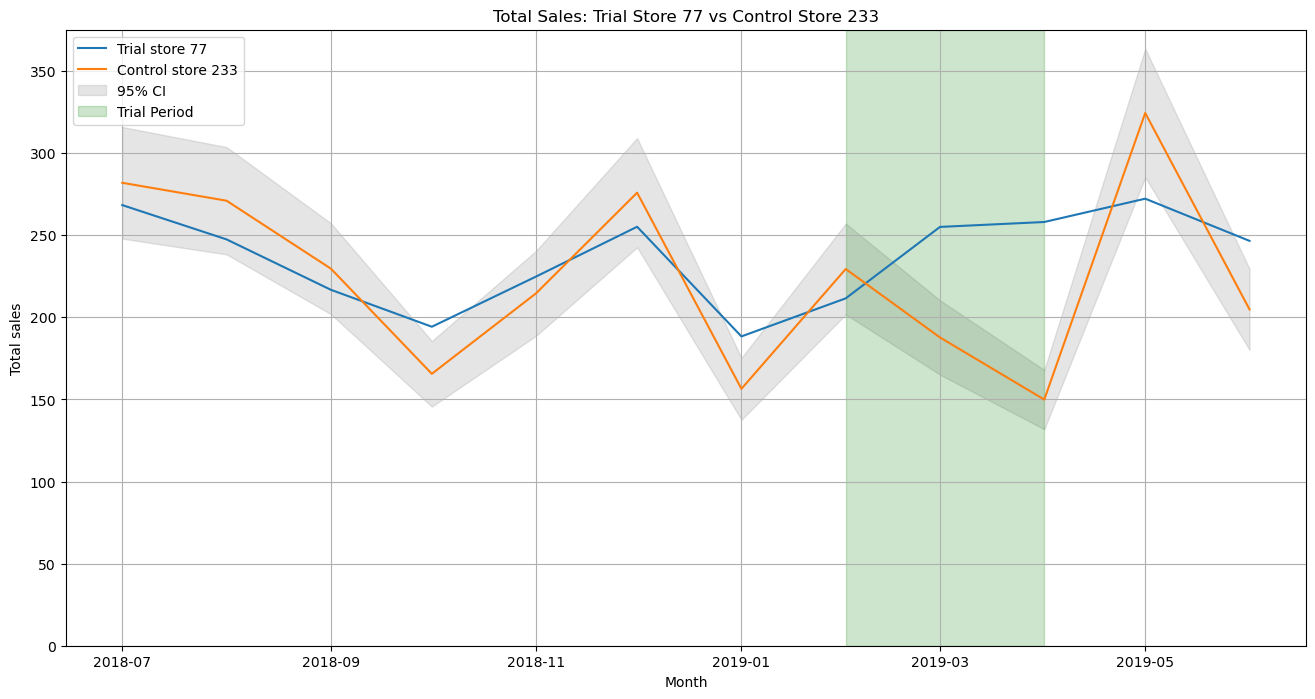

Results of trial store 77 compared to control store 233 (Metric: Number of customers) 


,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,77,233,2019-02-01,2.259470,1.894579
8,77,233,2019-03-01,9.530240,1.894579
9,77,233,2019-04-01,23.422793,1.894579


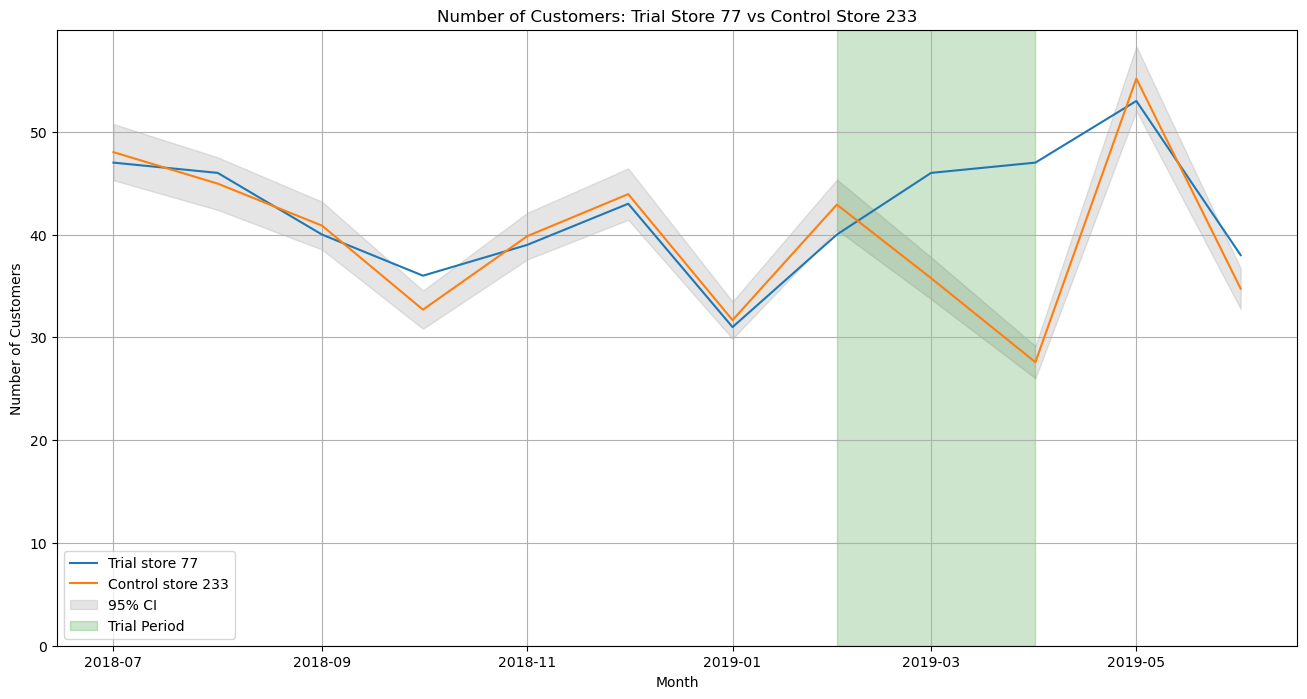

Results of trial store 86 compared to control store 155 (Metric: Total Sales) 


,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,86,155,2019-02-01,2.642804,1.894579
8,86,155,2019-03-01,12.796638,1.894579
9,86,155,2019-04-01,1.593697,1.894579


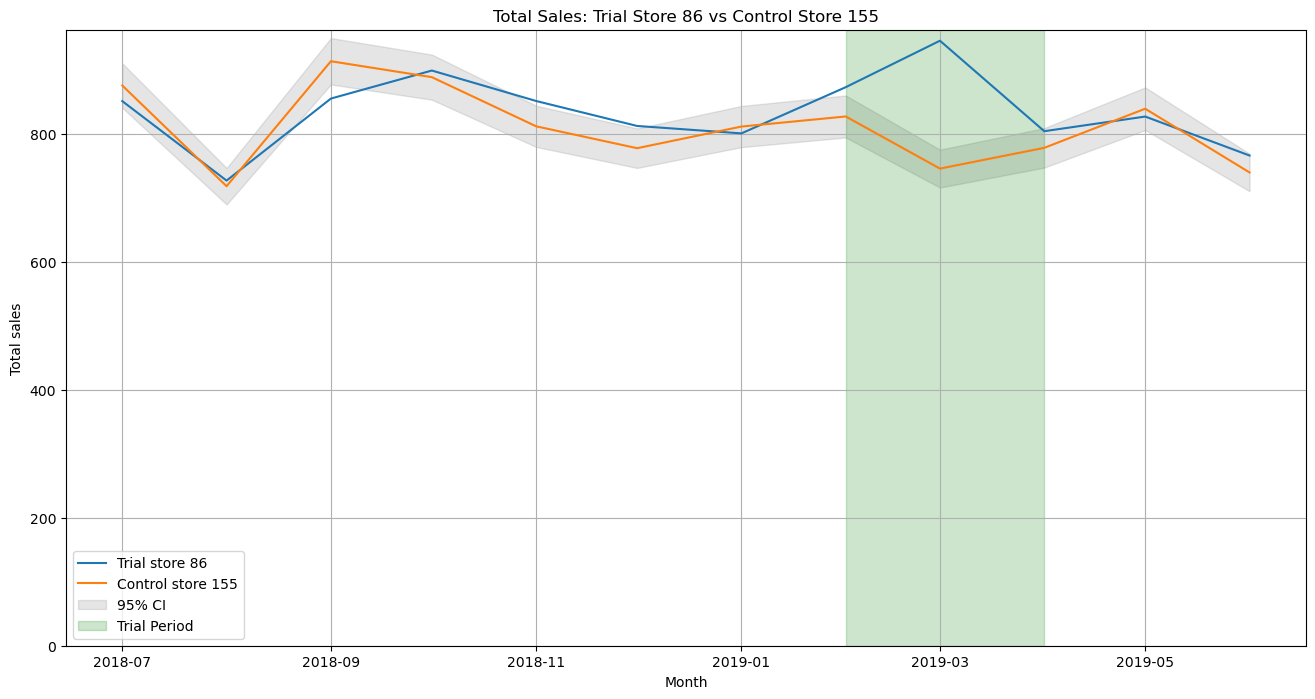

Results of trial store 86 compared to control store 155 (Metric: Number of customers) 


,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,86,155,2019-02-01,8.605720,1.894579
8,86,155,2019-03-01,11.437481,1.894579
9,86,155,2019-04-01,3.827618,1.894579


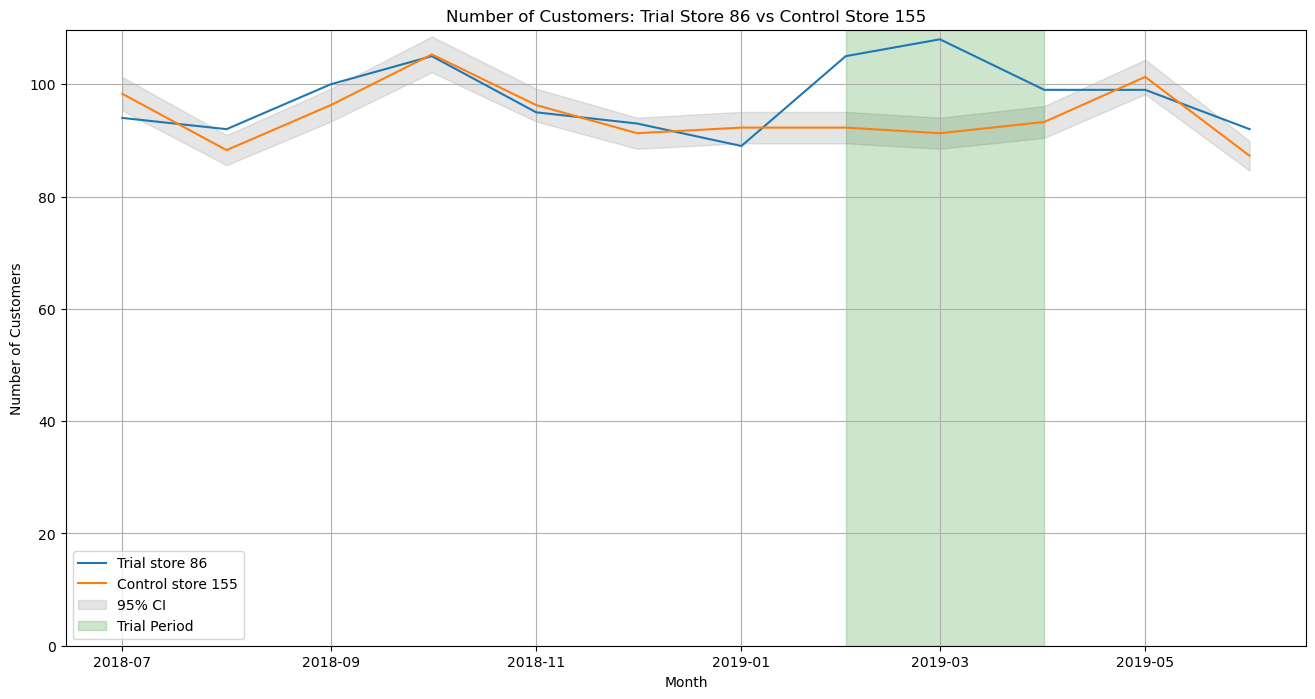

Results of trial store 88 compared to control store 237 (Metric: Total Sales) 


,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,88,237,2019-02-01,0.606487,1.894579
8,88,237,2019-03-01,5.243910,1.894579
9,88,237,2019-04-01,3.102824,1.894579


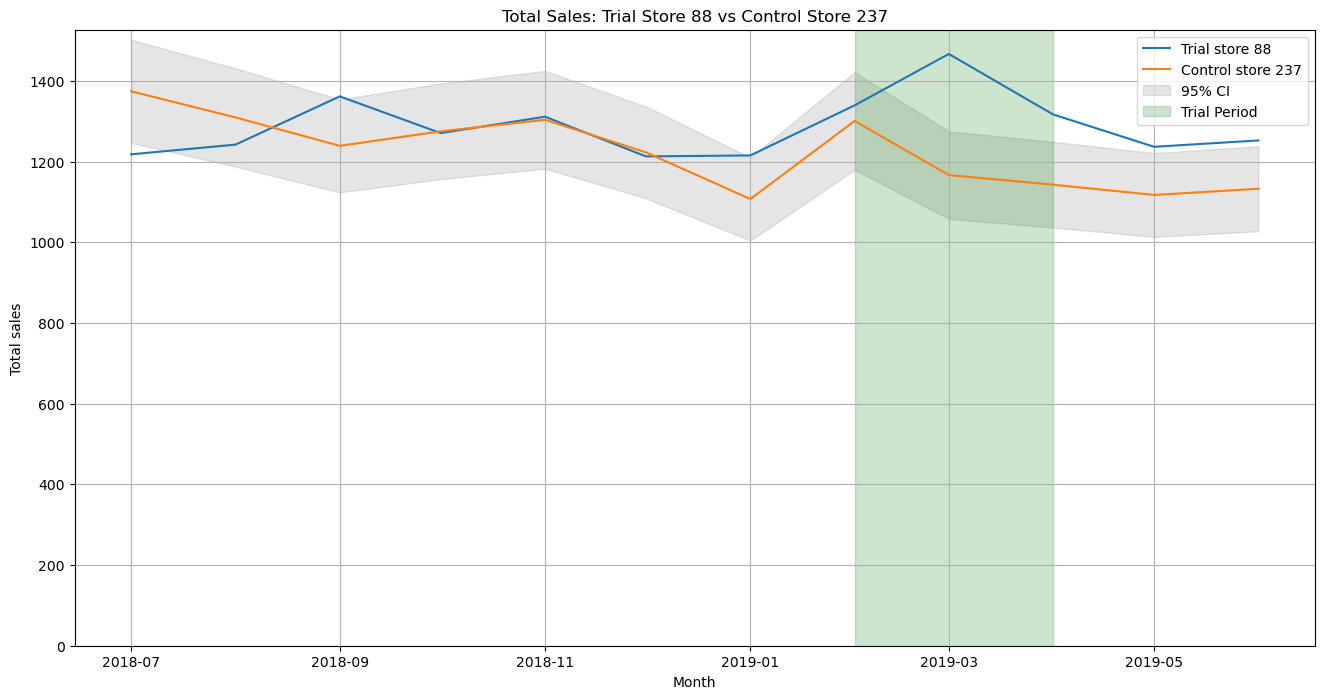

Results of trial store 88 compared to control store 237 (Metric: Number of customers) 


,store_nbr_x,store_nbr_y,yearmonth,tvalue,critical_tvalue
7,88,237,2019-02-01,1.677105,1.894579
8,88,237,2019-03-01,8.482095,1.894579
9,88,237,2019-04-01,1.713669,1.894579


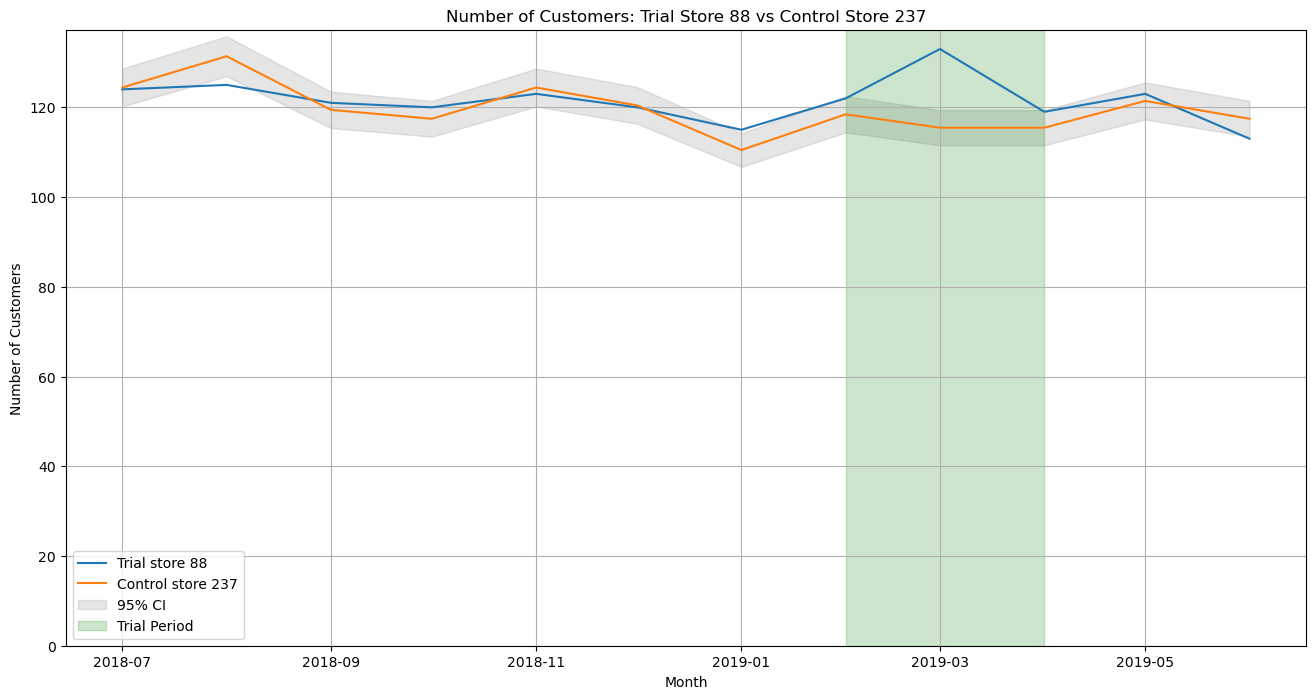

In [60]:
control_stores
metrics = ['totsales','n_customers']
for key,value in control_stores.items():
    for item in metrics:
        if item == 'n_customers':
            metric = 'Number of customers'
        else:
            metric = 'Total Sales'
        print(f'Results of trial store {key} compared to control store {value} (Metric: {metric}) ')
        display(get_Tscores(key,value,item))
        compare_trialvscontrol(key,value,item)
        plt.show()


# Findings and Conclusions

The trial in stores 77, 86, and 88 asked a simple question: did the intervention increase sales and customers from March to May 2019? This project investigated this question, and here’s what the data says.

## Results

Store 77 : The strategy had impact. Matched to a control store with similar pre trial sales and customer trends (July 2018–January 2019), store 77 showed significant gains in total sales and number of customers in two of the three trial months. T-tests confirmed these differences exceeded the critical t value (p < 0.05). Plots show trial metrics rising above control, with clear confidence intervals in those months.



Store 88: Similar success. Paired with a control store mirroring its pre trial performance, it had significant increases in sales and customers in two trial months, with t-tests passing the critical threshold. Visuals confirm the trial store’s metrics diverging upward from control in those periods.



Store 86: Mostly flat, but not entirely. Compared to its matched control, sales and customers showed no significant lift in two of three months, with t-tests below the critical value. However, one month stood out, with sales or customers exceeding the critical t value, suggesting partial or inconsistent impact. Plots show trial and control lines mostly aligned, with a brief divergence in that month.